# Reasoning

Let $s$ be the number of sentences in a corpus, $m$ the number of characters and $t(v)$ the number of tokens when tokenizing the corpus with vocabulary size $v$ and some tokenizer (e.g., wordpiece). Further let $c$ be the number of unique characters. 

We define the compression rate 
$r(v) = \frac{t(v)}{m}$

We want to model the function $r$. 

## Functional Form
We know that it is an exponential function and has the following constraints: 

$r(c) = 1$

$r(\infty) = \frac{t(v_{\max})}{m} =: a$

Let's model with 
$r_\theta(x) = \alpha (x / c)^\beta + \gamma$. 
With the constraints it holds: $\gamma = a$ and  $\alpha = 1 - a$. 
This gives us $r_\theta(x) = (1 - a) (x / c)^\beta + a$ and the only parameter is $\beta$.

We fit $\beta$ with a simple linear regression. 
I.e., $\log\left(\frac{(y - a)}{(1 - a)}\right) = \beta \log\left(\frac{x}{c}\right)$.

## Overall process
1. Sample uniform vocabulary sizes to get samples $[(v_1, r(v_1)), (v_2, r(v_2)), ...]$
2. Given this data fit the linear regression without intercept to get $\beta$. 
3. Now we have a model for our data. We want to sample according to the gradient (i.e., sample vocabulary sizes where the tokenization changes the most). Thus we can use simple inverse transform sampling (https://en.wikipedia.org/wiki/Inverse_transform_sampling) with our r_model

## TODO
This yields very small vocabulary sizes. Resolve this by adding a uniform prior...


In [1]:
import tokenizers
tokenizers.__version__

'0.10.1'

In [2]:
from scipy.optimize import curve_fit
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from data import PBC
from analyser import Corpus

ImportError: cannot import name 'Tokenizer' from 'tokenizer' (/Users/philipp/Dropbox/PhD/projects/subwordspaces/tokenizer.py)

In [4]:
pbc = PBC("/Users/philipp/Dropbox/data/2017_bible/corpus/")

In [5]:
pbc = PBC("/Users/philipp/Dropbox/data/2017_bible/corpus/")
pbc.load_editions(["eng_newworld2013", "deu_newworld", "zho_newworld", "swh_newworld"])

100%|██████████| 4/4 [00:00<00:00,  7.78it/s]


In [115]:
import collections
from typing import Text, List, Callable, Dict, Union, Any
import numpy as np
from tqdm import tqdm
import argparse
from embedder import EmbeddingTrainer
from tokenizer import Tokenizer
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LinearRegression
import numpy as np
import json
from tokenizers import Tokenizer
from tokenizers.models import BPE, WordPiece
from tokenizers.trainers import BpeTrainer, WordPieceTrainer
from tokenizers.pre_tokenizers import Whitespace


class TokenizerWrapper(object):
    def __init__(self, mode: Text):
        self.mode = mode
    
    def get_tokenizer(self, vocab_size: int):
        if self.mode == "BPE":
            self.tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
            self.tokenizer.pre_tokenizer = Whitespace()
            self.trainer = BpeTrainer(special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"], vocab_size=vocab_size)
        elif self.mode == "Wordpiece":
            self.tokenizer = Tokenizer(WordPiece(unk_token="[UNK]"))
            self.tokenizer.pre_tokenizer = Whitespace()
            self.trainer = WordPieceTrainer(vocab_size=vocab_size, special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])
        else:
            raise ValueError(f"Unknown mode: {self.mode}")

    def fit(self, data: Union[Text, List[Text]], vocab_size: int):
        self.get_tokenizer(vocab_size)
        if isinstance(data, str):
            self.tokenizer.train(data, trainer=self.trainer)
        else:
            self.tokenizer.train_from_iterator(data, trainer=self.trainer)
    
    def save(self, outpath: Text): 
        self.tokenizer.save(outpath)
    
    def load(self, path: Text):
        self.tokenizer.from_file(path)




class VocabSizeSampler(object):
    """docstring for VocabSizeSampler
    TODO add uniform prior such that we get a more heavy tail"""

    def __init__(self, eps=1e-2):
        self.params = {}
        self.eps = eps

    def load_parameters(self, file: Text):
        with open(file, "r") as fin:
            self.params = json.load(fin)

    def save_parameters(self, file: Text):
        outpath = os.path.join(file, "params.json")
        if os.path.exists(outpath):
            print(f"Warning, file exists: {outpath}")
        with open(file, "w") as outpath:
            json.dump(self.params, outpath)

    def sample(self, n_samples: int) -> List[int]:
        # sample using the inverse transform sampling
        uniforms = np.random.uniform(low=self.params["a"], high=1.0, size=n_samples)
        return [round(self.f_inv(u)) for u in uniforms]
    
    def f(self, x):
        return (1 - self.params["a"]) * (np.array(x) / self.params["c"]) ** self.params['beta'] + self.params["a"]
    
    def f_inv(self, x):
        return ((x - self.params["a"]) / (1 - self.params["a"])) ** (1 / self.params["beta"]) * self.params["c"]

    def f_grad(self, x):
        # not required
        return (1 - self.params["a"]) * self.params["beta"] * (1 / self.params["c"]) * (np.array(x) / self.params["c"]) ** (self.params['beta'] - 1)

    def f_grad_inv(self, x):
        # not required
        return self.params["c"] * (self.params["c"] * x / (self.params["beta"] * (1 - self.params["a"]))) ** (1 / (self.params["beta"] - 1))
    
    def plot_fit(self):
        xs, ys = zip(*self.compression.items())
        plt.scatter(xs, ys)
        plt.scatter(xs, [self.f(x) for x in xs], color="r")
        plt.show()

    def fit_regression(self, vocab_sizes: List[float], compression_rates: List[float]) -> None:
        # compute parameters
        # functional form: y = f_beta(x) = (1 - a) (x / c)^beta + a
        # where a = horizontal asymptote, i.e., min(compression_rates) - eps
        # and c = min(vocab_sizes), i.e., the number of characters in the corpus
        y = np.array(compression_rates)
        a = min(y) - self.eps
        y = (y - a) / (1 - a)
        xs = vocab_sizes
        c = min(xs)
        x = np.array(vocab_sizes) / c
        lr = LinearRegression(fit_intercept=False)
        lr.fit(np.log(x.reshape(-1, 1)), np.log(y))
        self.params = {"beta": float(lr.coef_),
                       "a": a,
                       "c": c,
                       "lower": int(self.vocab_size_min), 
                       "upper": int(self.vocab_size_max)}
    
    def set_corpus(self, data: List[Text]) -> None:
        self.data = data
    
    def set_tokenizer(self, tokenizer: TokenizerWrapper):
        self.tok = tokenizer
        # get true max and min vocab size with the tokenizer
        self.tok.fit(self.data, 0)
        self.vocab_size_min = self.tok.tokenizer.get_vocab_size()
        self.denominator = self.get_tokenization_length()
        self.tok.fit(self.data, 999999999)
        self.vocab_size_max = self.tok.tokenizer.get_vocab_size()
        print(f"Min vocab size: {self.vocab_size_min}")
        print(f"Max vocab size: {self.vocab_size_max}")
    
    def get_tokenization_length(self):
        length = 0
        for sentence in self.data:
            length += len(self.tok.tokenizer.encode(sentence).tokens)
        return length
        
    def get_compression_rates(self, outpath: Text, n_samples: int = 10) -> None:
        # do uniform sampling
        vocab_sizes = [self.vocab_size_min] + [int(x) for x in np.random.uniform(low=self.vocab_size_min, high=self.vocab_size_max, size=n_samples)] + [self.vocab_size_max]
        compression = {}
        for vocab_size in tqdm(vocab_sizes, desc="samples"):
            self.tok.fit(self.data, vocab_size)
            rate = self.get_tokenization_length() / self.denominator
            compression[self.tok.tokenizer.get_vocab_size()] = rate
            if outpath:
                os.path.makedirs(os.path.join(outpath, vocab_size))
                self.tok.save(os.path.join(outpath, vocab_size))
                with open(os.path.join(outpath, vocab_size, "rates.json"), "w") as fout:
                    json.dump(compression, fout) 
        self.compression = compression
        compression_sorted = sorted(compression.items(), key= lambda x: x[0])
        self.fit_regression(*zip(*compression_sorted))
        if outpath:
            self.save_parameters(outpath)

In [116]:
tokwrapper = TokenizerWrapper("Wordpiece")
tokwrapper.fit(["Das ist ein Test.", "Ein anderer Satz.", "das WETTER iSt schön."], 50)
tokwrapper.tokenizer.encode("Das ist ein Test. üt").tokens

['Das', 'i', '##st', 'e', '##in', 'Te', '##st', '.', '[UNK]']

In [117]:
tokwrapper = TokenizerWrapper("BPE")
sampler = VocabSizeSampler(eps=0.01)
#sampler.set_corpus(pbc.text["eng"]["eng_newworld2013"].values())
sampler.set_corpus(pbc.text["zho"]["zho_newworld"].values())
sampler.set_tokenizer(tokwrapper)
sampler.get_compression_rates(None, 2)



samples:   0%|          | 0/4 [00:00<?, ?it/s]

Min vocab size: 3413
Max vocab size: 29717



samples: 100%|██████████| 4/4 [00:12<00:00,  3.19s/it]


<IPython.core.display.Javascript object>


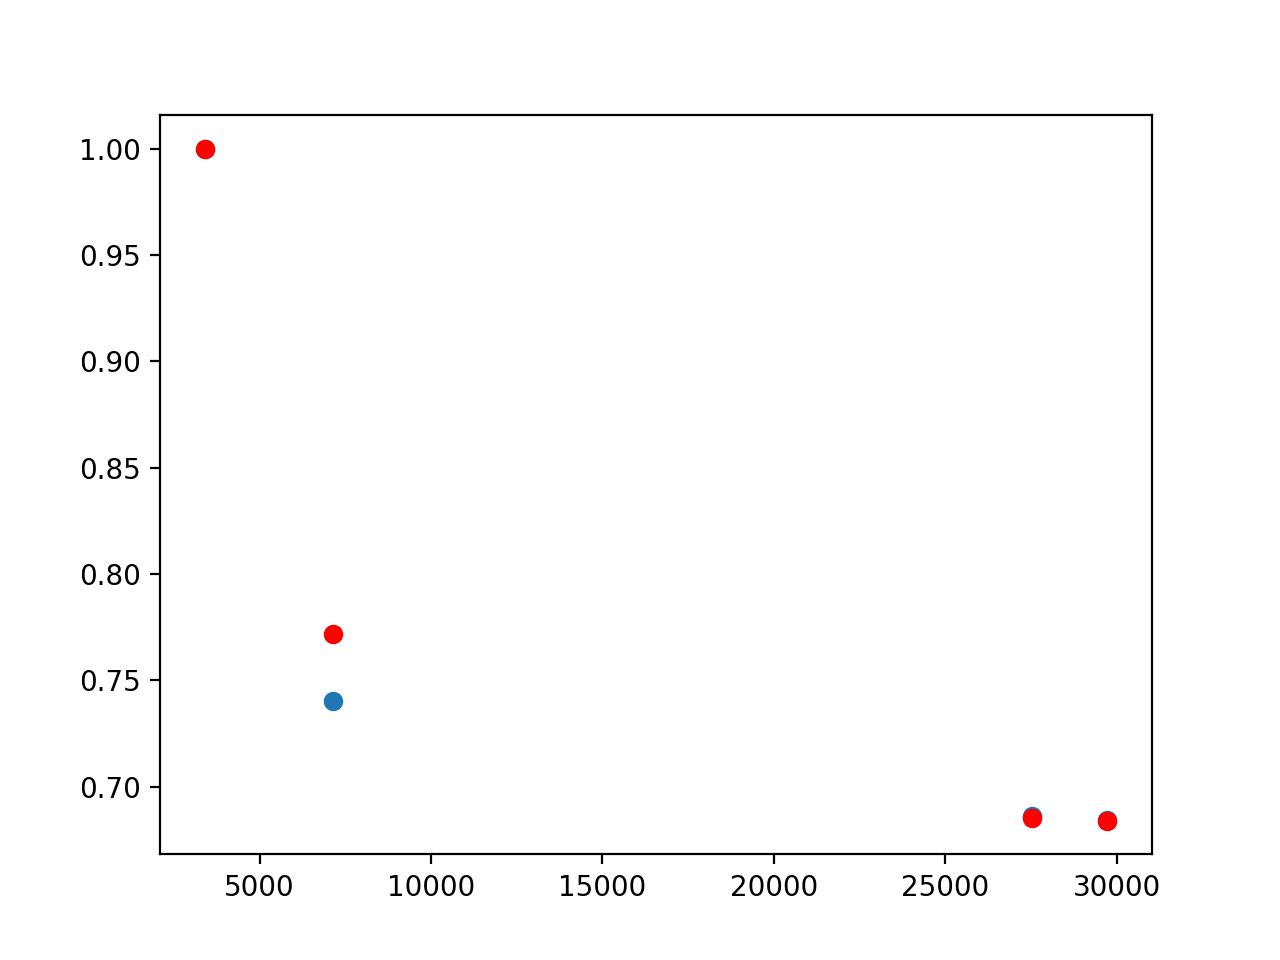

In [118]:
sampler.plot_fit()

In [15]:
sampler.sample(10)

[4379, 34336, 4136, 6145, 15264, 5059, 8237, 3737, 4097, 3548]

In [25]:
sampler.f_inv(0.6780241994497448 + sampler.eps)

24005.047721241877

In [23]:
sampler.params

{'beta': -1.7798432936849935,
 'a': 0.6780241994497448,
 'c': 3413,
 'lower': 3408,
 'upper': 25977}

## GET VOCABSIZES


In [119]:
pbc = PBC("/Users/philipp/Dropbox/data/2017_bible/corpus/")
editions = [
            ("zho", "zho_newworld"), 
            ("eng", "eng_newworld2013"), 
            ("deu", "deu_newworld"), 
            ("rus", "rus_newworld"), 
            ("hin", "hin_newworld"),
            ("ell", "ell_newworld"),
           ]
pbc.load_editions([x[1] for x in editions])



100%|██████████| 6/6 [00:00<00:00,  7.95it/s]


In [122]:
results = []
for lang, edition in editions:
    tokwrapper = TokenizerWrapper("Wordpiece")
    sampler = VocabSizeSampler(eps=0.001)
    sampler.set_corpus(pbc.text[lang][edition].values())
    sampler.set_tokenizer(tokwrapper)
    sampler.get_compression_rates(None, 11)
    cr = 1.0
    results.append((lang, "max", 1.0, sampler.params["lower"]))
    while cr > sampler.params["a"]:
        results.append((lang, "f", cr, sampler.f_inv(cr)))
        print("{} {} {:.2f} {:.0f}".format(*results[-1]))
        cr -= 0.05
    results.append((lang, "min", sampler.params["a"], sampler.params["upper"]))


samples:   0%|          | 0/13 [00:00<?, ?it/s]

Min vocab size: 6189
Max vocab size: 33786



samples: 100%|██████████| 13/13 [00:37<00:00,  2.90s/it]


zho f 1.00 6189
zho f 0.95 6567
zho f 0.90 7054
zho f 0.85 7722
zho f 0.80 8733
zho f 0.75 10592
zho f 0.70 17083



samples:   0%|          | 0/13 [00:00<?, ?it/s]

Min vocab size: 129
Max vocab size: 18865



samples: 100%|██████████| 13/13 [00:41<00:00,  3.18s/it]


eng f 1.00 129
eng f 0.95 138
eng f 0.90 147
eng f 0.85 159
eng f 0.80 172
eng f 0.75 189
eng f 0.70 209
eng f 0.65 234
eng f 0.60 267
eng f 0.55 311
eng f 0.50 374
eng f 0.45 473
eng f 0.40 653
eng f 0.35 1087
eng f 0.30 4139



samples:   0%|          | 0/13 [00:00<?, ?it/s]

Min vocab size: 173
Max vocab size: 42224



samples: 100%|██████████| 13/13 [00:53<00:00,  4.12s/it]


deu f 1.00 173
deu f 0.95 184
deu f 0.90 197
deu f 0.85 212
deu f 0.80 230
deu f 0.75 251
deu f 0.70 276
deu f 0.65 307
deu f 0.60 346
deu f 0.55 397
deu f 0.50 467
deu f 0.45 569
deu f 0.40 730
deu f 0.35 1025
deu f 0.30 1759
deu f 0.25 7267



samples:   0%|          | 0/13 [00:00<?, ?it/s]

Min vocab size: 137
Max vocab size: 59341



samples: 100%|██████████| 13/13 [00:56<00:00,  4.34s/it]


rus f 1.00 137
rus f 0.95 148
rus f 0.90 161
rus f 0.85 176
rus f 0.80 195
rus f 0.75 217
rus f 0.70 244
rus f 0.65 278
rus f 0.60 323
rus f 0.55 384
rus f 0.50 471
rus f 0.45 603
rus f 0.40 827
rus f 0.35 1281
rus f 0.30 2632
rus f 0.25 29117



samples:   0%|          | 0/13 [00:00<?, ?it/s]

Min vocab size: 144
Max vocab size: 10481



samples: 100%|██████████| 13/13 [00:18<00:00,  1.45s/it]


hin f 1.00 144
hin f 0.95 153
hin f 0.90 164
hin f 0.85 176
hin f 0.80 191
hin f 0.75 209
hin f 0.70 231
hin f 0.65 259
hin f 0.60 295
hin f 0.55 344
hin f 0.50 417
hin f 0.45 534
hin f 0.40 762
hin f 0.35 1427



samples:   0%|          | 0/13 [00:00<?, ?it/s]

Min vocab size: 143
Max vocab size: 51077



samples: 100%|██████████| 13/13 [01:03<00:00,  4.92s/it]

ell f 1.00 143
ell f 0.95 154
ell f 0.90 167
ell f 0.85 183
ell f 0.80 201
ell f 0.75 223
ell f 0.70 251
ell f 0.65 285
ell f 0.60 330
ell f 0.55 390
ell f 0.50 475
ell f 0.45 604
ell f 0.40 821
ell f 0.35 1256
ell f 0.30 2524
ell f 0.25 24928


In [123]:
for result in results:
    print("{} {} {:.2f} {:.0f}".format(*result))

zho max 1.00 6189
zho f 1.00 6189
zho f 0.95 6567
zho f 0.90 7054
zho f 0.85 7722
zho f 0.80 8733
zho f 0.75 10592
zho f 0.70 17083
zho min 0.68 33786
eng max 1.00 129
eng f 1.00 129
eng f 0.95 138
eng f 0.90 147
eng f 0.85 159
eng f 0.80 172
eng f 0.75 189
eng f 0.70 209
eng f 0.65 234
eng f 0.60 267
eng f 0.55 311
eng f 0.50 374
eng f 0.45 473
eng f 0.40 653
eng f 0.35 1087
eng f 0.30 4139
eng min 0.29 18865
deu max 1.00 173
deu f 1.00 173
deu f 0.95 184
deu f 0.90 197
deu f 0.85 212
deu f 0.80 230
deu f 0.75 251
deu f 0.70 276
deu f 0.65 307
deu f 0.60 346
deu f 0.55 397
deu f 0.50 467
deu f 0.45 569
deu f 0.40 730
deu f 0.35 1025
deu f 0.30 1759
deu f 0.25 7267
deu min 0.24 42224
rus max 1.00 137
rus f 1.00 137
rus f 0.95 148
rus f 0.90 161
rus f 0.85 176
rus f 0.80 195
rus f 0.75 217
rus f 0.70 244
rus f 0.65 278
rus f 0.60 323
rus f 0.55 384
rus f 0.50 471
rus f 0.45 603
rus f 0.40 827
rus f 0.35 1281
rus f 0.30 2632
rus f 0.25 29117
rus min 0.24 59341
hin max 1.00 144
hin f 1.00

In [100]:
tokwrapper = TokenizerWrapper("Wordpiece")
tokwrapper.fit(pbc.text[lang][edition].values(), 999999999)
tokwrapper.tokenizer.encode(list(pbc.text[lang][edition].values())[0]).tokens

In [ ]:
len(tokwrapper.tokenizer.get_vocab())

# PLAY AROUND

In [7]:
from embedder import TokenizerWrapper

In [8]:
def get_tokenization_length(tok, data):
    total = 0
    for sentence in data:
        total += len(tok.tokenize(sentence))
    return total

In [23]:
data = pbc.text["zho"]["zho_newworld"].values()
#data = pbc.text["eng"]["eng_newworld2013"].values()

In [24]:
charwrap = TokenizerWrapper("BPE")
charwrap.fit(data, 0)
char_types = charwrap.tokenizer.get_vocab_size()
char_types

3414

In [15]:
maxwrap = TokenizerWrapper("BPE")
maxwrap.fit(data, 100000)
maxwrap.tokenizer.get_vocab_size()

100000

In [25]:
rates = []
#for size in [129, 500, 1000, 5000, 10000, 18000]:
#for size in [6189, 7000, 10000, 15000, 20000, 30000]:
#for size in [128, 500, 1000, 5000, 10000, 18000, 40000]:
#for size in [6189, 7000, 10000, 30000, 50000, 75000, 90000]:
for size in [50000]:
    curwrap = TokenizerWrapper("BPE")
    curwrap.fit(data, size)
    types = curwrap.tokenizer.get_vocab_size()
    rate = (get_tokenization_length(curwrap, data) / types) / (get_tokenization_length(charwrap, data) / char_types)
    
    #subtract = 1 / (get_tokenization_length(charwrap, data) / char_types)
    rates.append(rate)
    print(size, rate)

50000 0.01653416016448563


In [38]:
curwrap.tokenize(list(data)[5])

['上帝 説 : “ ',
 '水',
 ' 和 水',
 ' 之間',
 ' 要 有 ',
 '天空',
 ' ， 把 ',
 '水上 ',
 '下 ',
 '分開 。 ”']

In [39]:
engwrap.tokenize(list(pbc.text["eng"]["eng_newworld2013"].values())[5])

['Then God ',
 'said : “ ',
 'Let ',
 'there ',
 'be ',
 'an ',
 'ex',
 'pan',
 'se ',
 'between the ',
 'waters ',
 ', and let ',
 'there ',
 'be ',
 'a ',
 'division ',
 'between the ',
 'waters ',
 'and the ',
 'waters ',
 '. ”']

In [26]:
engwrap = TokenizerWrapper("BPE")
engwrap.fit(list(pbc.text["eng"]["eng_newworld2013"].values()), 8500)
engwrap.tokenizer.get_vocab_size()

8500

'Now the earth was formless and desolate , and there was darkness upon the surface of the watery deep , and God’s active force was moving about over the surface of the waters .'

In [22]:
list(pbc.text["zho"]["zho_newworld"].values())[1]

'大地 混沌 蒼茫 ， 深淵 的 表面 一 片 黑暗 。 上帝 發出 的 動力 運行 在 水面 上 。'

In [26]:
rates

[1.0,
 0.12341619773240924,
 0.051784732998657615,
 0.007895423405574503,
 0.0037609070598380897,
 0.0020577553373012838]

In [31]:
rates

[1.0,
 0.7231187038384375,
 0.4593342872879279,
 0.2931013337236098,
 0.2160691452252764,
 0.14185256582234743]

# get compatible sizes


In [40]:
datazho = pbc.text["zho"]["zho_newworld"].values()
dataeng = pbc.text["eng"]["eng_newworld2013"].values()

In [55]:
charwrap = TokenizerWrapper("BPE")
charwrap.fit(datazho, 0)
char_types = charwrap.tokenizer.get_vocab_size()
curwrap = TokenizerWrapper("BPE")
curwrap.fit(datazho, 10000)
types = curwrap.tokenizer.get_vocab_size()
#rate = (get_tokenization_length(curwrap, datazho) / types) / (get_tokenization_length(charwrap, datazho) / char_types)
rate = get_tokenization_length(curwrap, datazho)
rate

685677

In [56]:
echarwrap = TokenizerWrapper("BPE")
echarwrap.fit(dataeng, 0)
char_types = echarwrap.tokenizer.get_vocab_size()
ecurwrap = TokenizerWrapper("BPE")
ecurwrap.fit(dataeng, 11000)
types = ecurwrap.tokenizer.get_vocab_size()
#rate = (get_tokenization_length(ecurwrap, dataeng) / types) / (get_tokenization_length(echarwrap, dataeng) / char_types)
rate = get_tokenization_length(ecurwrap, dataeng)
rate

676043

In [64]:
ecurwrap.tokenize(list(dataeng)[1])

['Now the ',
 'earth ',
 'was ',
 'form',
 'less ',
 'and ',
 'desolate ',
 ', and there was ',
 'darkness ',
 'upon the ',
 'surface of the ',
 'water',
 'y ',
 'deep ',
 ', and ',
 'God’s ',
 'ac',
 'ti',
 've ',
 'force ',
 'was ',
 'moving ',
 'about ',
 'over the ',
 'surface of the ',
 'waters .']

In [61]:
curwrap.tokenize(list(datazho)[0])

['最初', ' ， 上帝 ', '創', '造 了 ', '天', '地 。']

# plots for paper

In [1]:
from data import PBC
from embedder import TokenizerWrapper
from get_vocab_sizes import Measure

In [2]:
pbc = PBC("/Users/philipp/Dropbox/data/2017_bible/corpus/")
pbc.load_editions(["eng_newworld2013", "deu_newworld", "zho_newworld", "swh_newworld"])

100%|██████████| 4/4 [00:00<00:00,  6.20it/s]


In [3]:
tok = TokenizerWrapper("BPE", "")

In [4]:
zho = Measure(list(pbc.text["zho"]["zho_newworld"].values()), tok)
eng = Measure(list(pbc.text["eng"]["eng_newworld2013"].values()), tok)

In [5]:
results_zho = {}
for size in [3413, 3500, 4000, 5000, 7500, 10000, 20000, 30000, 40000]:
    results_zho[size] = zho.get_measures(size)
    print(size, results_zho[size])

3413 (1.0, 1.0, 1.0)
3500 (0.6644770083261706, 0.6481498589787276, 0.6484976013123148)
4000 (0.5205395421259298, 0.444280499204481, 0.4450763228260081)
5000 (0.45282089197401043, 0.3091861050398543, 0.3101600202409889)
7500 (0.38925461570816866, 0.17718870107035836, 0.17835604636413263)
10000 (0.35827196037296644, 0.12231404727133074, 0.12346836968372853)
20000 (0.3021294827951062, 0.05157350271312462, 0.05243925496912157)
30000 (0.27491829275620544, 0.03128570171565618, 0.032100166461361296)
40000 (0.2567595599434646, 0.0219144284411747, 0.02267658073647687)


In [8]:
zho.tokenizer.tokenizer.get_vocab_size()

TypeError: Can't convert '最初 ， 上帝 創造 了 天地 。' to PyBool

In [9]:
zho.tokenizer.tokenize(list(pbc.text["zho"]["zho_newworld"].values())[0])

['最初', ' ， 上帝 ', '創', '造 了 天', '地 。']

In [17]:
eng.get_tokenization_length(100000)

(378311, 100000, 83296)

In [13]:
results_eng = {}
for size in [84, 100, 150, 200, 500, 1000, 5000, 10000, 50000, 100000]:
    results_eng[size] = eng.get_measures(size)
    print(size, results_eng[size])

84 (1.0, 1.0, 1.0)
100 (0.8043385291602008, 0.6756443644945687, 0.6688709874069039)
150 (0.6423100272125011, 0.3596936152390006, 0.3523784177068582)
200 (0.573882293285583, 0.2410305631799449, 0.23369433592557246)
500 (0.44604471650409366, 0.07493551237268774, 0.07176686884689083)
1000 (0.38424186772112656, 0.03227631688857463, 0.0307861131338428)
5000 (0.3031234962828406, 0.005092474737551722, 0.004928330151542377)
10000 (0.2906128636421927, 0.0024411480545944186, 0.002466790182414658)
50000 (0.286871880062637, 0.0013530172894588156, 0.0016134756176098765)
100000 (0.286871880062637, 0.0013530172894588156, 0.0016134756176098765)


In [18]:
eng.tokenizer.tokenize(list(pbc.text["eng"]["eng_newworld2013"].values())[10])

['Then God said : “ Let the earth ',
 'cause ',
 'grass to sprout ',
 ', seed-bearing plants and ',
 'fruit trees ',
 'according to their kinds , ',
 'yielding fruit along with ',
 'seed ',
 'on the earth ',
 '. ” And it was so .']

In [16]:
len(list(pbc.text["eng"]["eng_newworld2013"].values()))

31062